<a href="https://colab.research.google.com/github/priyabhayani19/DL-Smarter-Literature-Review-with-Embedding-/blob/main/Neural_Style_Transfer_by_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style transfer

#Setup

#Import and configure modules

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display # Import IPython display module for showing images in notebook

# Import matplotlib for plotting images and customizing plots
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set default figure size for all plots and disable grid lines
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
# Converts a TensorFlow tensor to a PIL image for visualization
def tensor_to_image(tensor):
  tensor = tensor*255 #Rescale pixel values from [0, 1] to [0, 255]
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:



In [ ]:

content_path = tf.keras.utils.get_file('tiger.JPEG', 'https://drive.google.com/uc?export=download&id=1Di-XvqMHECEzCg_sr9j-BNX6EliBYjxd')
style_path = tf.keras.utils.get_file('birds.JPEG', 'https://drive.google.com/uc?export=download&id=1myH3Rc0hFW4Gky5aZMpgF-ZMnAymp6Ly')


840799/840799 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1368245/1368245 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.



In [ ]:
def load_img(path_to_img): #  # Load image from file path
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)# decode the img with RGB
  img = tf.image.convert_image_dtype(img, tf.float32)# convert img to float

 # Resize image while maintaining aspect ratio
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :] # Add batch dimension to the image
  return img

Create a simple function to display an image:



In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

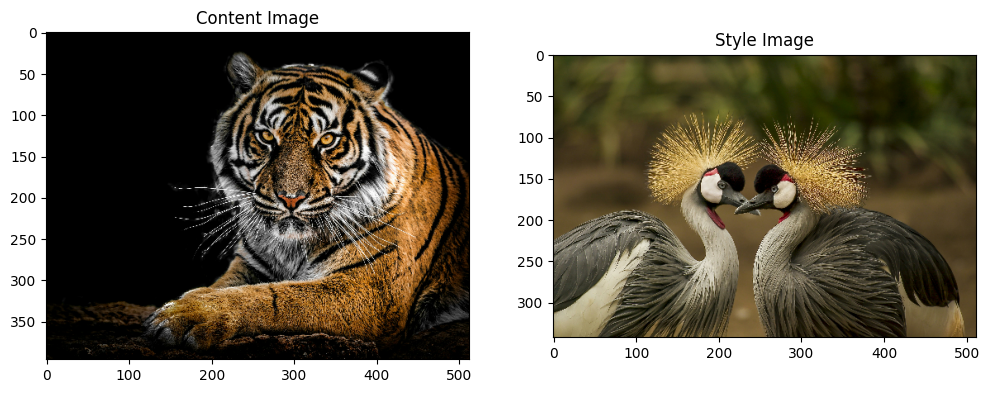

In [ ]:
# lodig and displaying the img
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Fast Style Transfer using TF-Hub

let's see how the TensorFlow Hub model does this:

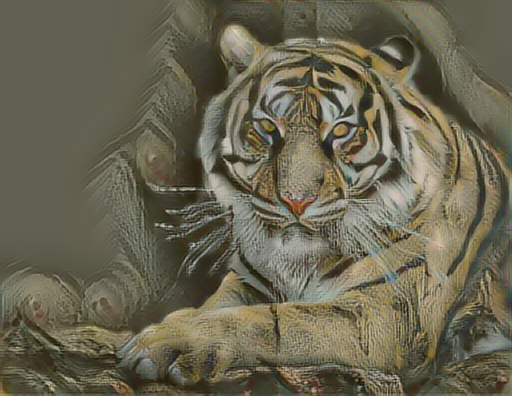

In [ ]:
import tensorflow_hub as hub  # import tensorflow hub to use pretrained model

# pre-trained machine learning models from tensorflow hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0] #Applay style transfer using model

tensor_to_image(stylized_image) # convert stylized output to an image formate

#Define content and style representations

Load a VGG19 and test run it on our image



In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # Preprocess the img : convert the RGB to BGR

x = tf.image.resize(x, (224, 224)) # resize the img to require input size for VGG19

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5] ## This will display the top 5 predicted classes with their probabilities

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('tiger', np.float32(0.83079547)),
 ('tiger_cat', np.float32(0.16175866)),
 ('jaguar', np.float32(0.003301255)),
 ('tabby', np.float32(0.0014058836)),
 ('lynx', np.float32(0.0008856199))]

 load a VGG19 without the classification head, and list the layer names

In [ ]:
# Load pre-trained VGG19 without fully connected layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:



In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1', # Early layers capture
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'] # Deeper layers capture

#content loss calculation
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#Build the model

This following function builds a VGG19 model that returns a list of intermediate layer outputs:



In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]  # Extract the outputs of the specified intermediate layers

  model = tf.keras.Model([vgg.input], outputs)  # Create a new model that takes the same input as VGG19 but returns the selected layer outputs

  return model

And to create the model:



In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 342, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 342, 512, 64)
  min:  0.0
  max:  776.05365
  mean:  20.262463

block2_conv1
  shape:  (1, 171, 256, 128)
  min:  0.0
  max:  3654.0798
  mean:  108.389404

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  6231.8267
  mean:  105.97469

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  12831.266
  mean:  426.07663

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3020.6023
  mean:  41.033905



#Calculate style

In [ ]:
def gram_matrix(input_tensor):#The Gram matrix is used to measure the style (texture) of an image by computing

  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  # Get spatial dimensions to normalize the result
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

  return result/(num_locations)

#Extract style and content

Custom model to extract style and content features from an image using VGG19

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False #Freeze the VGG model weights

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # Preprocess input for VGG19
    outputs = self.vgg(preprocessed_input) # Pass the input through the VGG model to get outputs from selected layers


    # Split outputs into style and content parts
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    #Compute Gram matrices for style outputs
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

# Pass the content image through the model
results = extractor(tf.constant(content_image))

# Display extracted style features
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

# Display extracted content features
print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 396, 512, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.20287845
    max:  57366.383
    mean:  870.3735

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  198850.4
    mean:  29189.523

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  505064.88
    mean:  22510.885

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9202533.0
    mean:  339430.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  166433.17
    mean:  1962.5607

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1664.0178
    mean:  15.925677


#Run gradient descent

Set your style and content target values:



In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 342, 512, 3))
  warnings.warn(msg)


Define a tf.Variable to contain the image to optimize

In [ ]:
image = tf.Variable(content_image)

 define a function to keep the pixel values between 0 and 1:



In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:



In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
  # Extract the style and content outputs from the model's results
    style_outputs = outputs['style']
    content_outputs = outputs['content']

     # Calculate style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Calculate content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use tf.GradientTape to update the image.



In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)  # Get the style and content features from the image
    loss = style_content_loss(outputs)# Compute the total loss

 #Calculate gradients of the loss with respect to the image
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image)) # Clip pixel values to maintain valid image range [0, 1]

Now run a few steps to test:



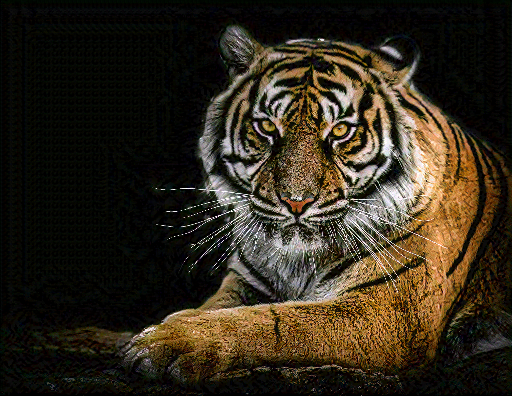

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:



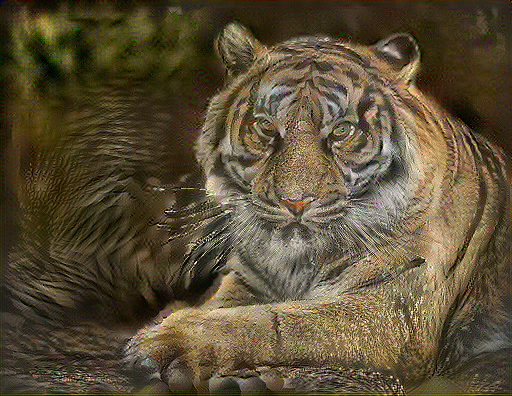

Train step: 1000
Total time: 8639.2


In [ ]:
import time
start = time.time() # Record the starting time to measure total training time

epochs = 10 # Number of training epochs
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)

  # display updated image after each epoch
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#Total variation loss

Calculate the difference along the x-axis and y-axis

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

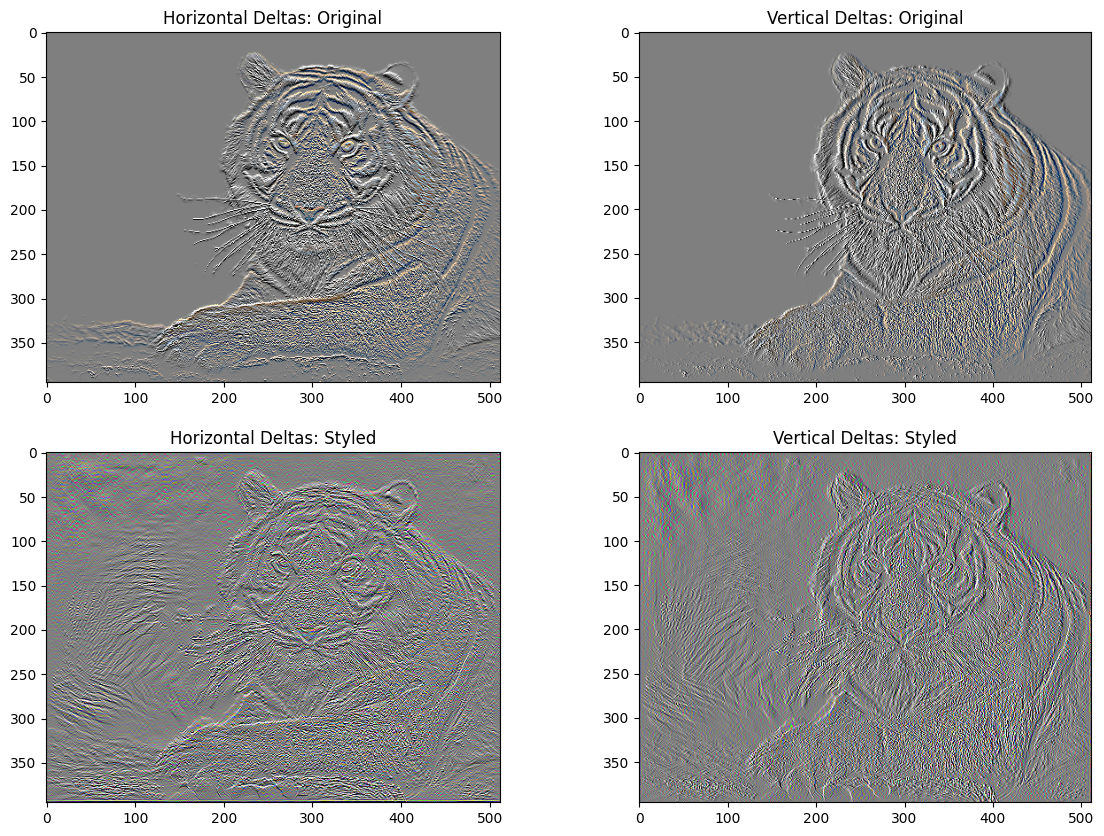

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

.

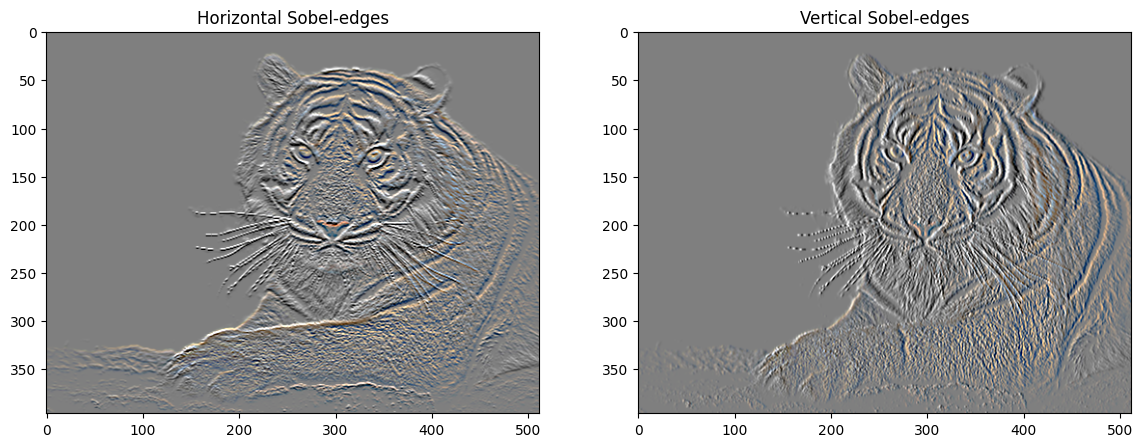

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:



In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

Compute total variation loss and convert to NumPy

In [ ]:
total_variation_loss(image).numpy()

np.float32(114625.2)

In [ ]:
tf.image.total_variation(image).numpy()

array([114625.2], dtype=float32)

#Re-run the optimization

Choose a weight for the total_variation_loss:



In [ ]:
total_variation_weight=30

Now include it in the train_step function:



In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image) # Run the image through the extractor model
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image) # Add total variation loss

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:



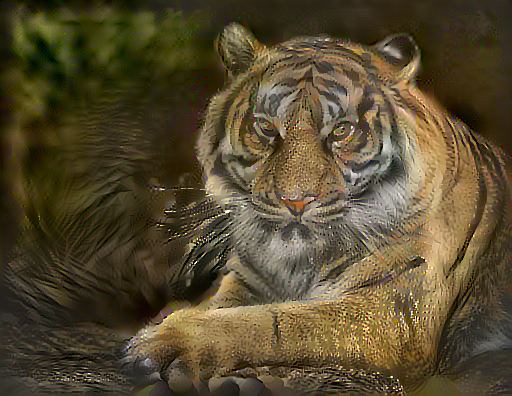

Train step: 1000
Total time: 8519.4


In [ ]:
import time
start = time.time() # Record the start time for measuring total training duration

style_weight = 1e-2  # Weight for style loss
content_weight = 1e4  # Weight for content loss
total_variation_weight = 30  # Weight for total variation loss

epochs = 10
steps_per_epoch = 100


step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)# After each epoch update the display with the current image
  display.display(tensor_to_image(image)) # Show the updated image
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:



In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>